In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use({'figure.facecolor':'white'})
sns.set_theme(style='whitegrid')
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import imagenet_utils, inception_resnet_v2, EfficientNetB0, InceptionResNetV2
from tensorflow.keras.utils import to_categorical

In [2]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_val = X_train[40000:]
y_val = y_train[40000:]
X_train = X_train[:40000]
y_train = y_train[:40000]

169017344/169001437 [==============================] - 6s 0us/step


In [3]:
x_train = inception_resnet_v2.preprocess_input(X_train)
x_val = inception_resnet_v2.preprocess_input(X_val)
x_test = inception_resnet_v2.preprocess_input(X_test)

In [4]:
y_train = to_categorical(y_train, 100)
y_val = to_categorical(y_val, 100)
y_test = to_categorical(y_test, 100)

In [5]:
inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))
inception_resnet.summary()

2022-03-24 05:03:01.268369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 05:03:01.383353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 05:03:01.384502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 05:03:01.386143: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

219070464/219055592 [==============================] - 5s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_____________

In [6]:
model = Sequential([
        UpSampling2D(),
        UpSampling2D(),
        UpSampling2D(),
        inception_resnet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(100, activation='softmax')
])

sgd = SGD(learning_rate=10e-3, momentum=0.9, decay=0.000001)

In [7]:
model.compile(optimizer=sgd , loss = 'categorical_crossentropy', metrics=['accuracy'])

In [8]:
checkpoint = ModelCheckpoint(filepath='./model.h5',
                             monitor = 'val_accuracy',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')

early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=5,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              patience= 3,
                              factor= 0.3,
                              min_lr= 1e-6,
                              verbose=1)

In [9]:
augment = ImageDataGenerator(rotation_range=30, shear_range=0.2,
                               horizontal_flip=True,fill_mode='nearest')

In [10]:
H = model.fit_generator(augment.flow(x_train, y_train, batch_size=32), validation_data=(x_val, y_val),
                        steps_per_epoch=len(x_train)//32, verbose=1, epochs = 20, callbacks=[checkpoint, early_stop, reduce_lr])
model.save_weights('resnet_weights.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-24 05:03:19.463972: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-03-24 05:03:25.329088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
1250/1250 [==============================] - 585s 449ms/step - loss: 3.1256 - accuracy: 0.2412 - val_loss: 1.9332 - val_accuracy: 0.4877

Epoch 00001: val_accuracy improved from -inf to 0.48770, saving model to ./model.h5
Epoch 2/20
1250/1250 [==============================] - 557s 446ms/step - loss: 1.6653 - accuracy: 0.5544 - val_loss: 1.4516 - val_accuracy: 0.6150

Epoch 00002: val_accuracy improved from 0.48770 to 0.61500, saving model to ./model.h5
Epoch 3/20
1250/1250 [==============================] - 557s 446ms/step - loss: 1.2910 - accuracy: 0.6511 - val_loss: 1.0919 - val_accuracy: 0.6997

Epoch 00003: val_accuracy improved from 0.61500 to 0.69970, saving model to ./model.h5
Epoch 4/20
1250/1250 [==============================] - 554s 443ms/step - loss: 1.0776 - accuracy: 0.7053 - val_loss: 1.0615 - val_accuracy: 0.7040

Epoch 00004: val_accuracy improved from 0.69970 to 0.70400, saving model to ./model.h5
Epoch 5/20
1250/1250 [==============================] - 552

In [11]:
def plot_acc_loss(H):
    fig, ax = plt.subplots(1,2, figsize=(14,7))
    ax[0].plot(H.history['accuracy'])
    ax[0].plot(H.history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(H.history['loss'])
    ax[1].plot(H.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper right')
    plt.show()

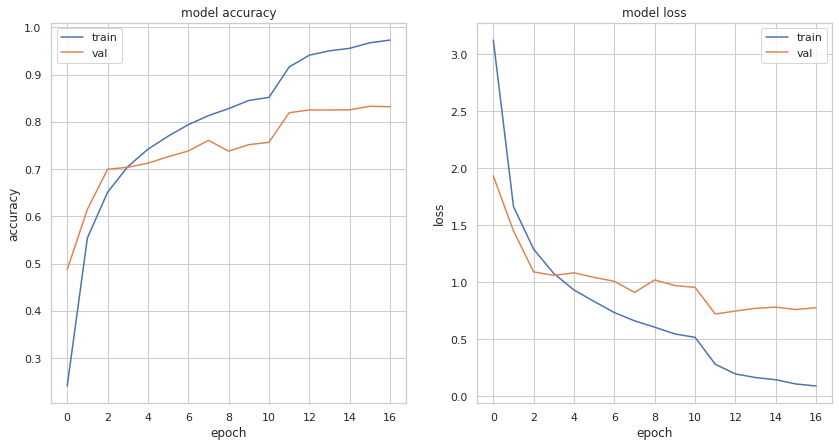

In [12]:
plot_acc_loss(H)

In [17]:
score = model.evaluate(x_train, y_train)
print(f'Train loss: {score[0]:.4f}')
print(f'Train accuracy: {score[1]:.4f}')

1250/1250 [==============================] - 165s 129ms/step - loss: 0.1018 - accuracy: 0.9675
Train loss: 0.1018
Train accuracy: 0.9675


In [18]:
score = model.evaluate(x_val, y_val)
print(f'Val loss: {score[0]:.4f}')
print(f'Val accuracy: {score[1]:.4f}')

313/313 [==============================] - 41s 131ms/step - loss: 0.7231 - accuracy: 0.8194
Val loss: 0.7231
Val accuracy: 0.8194


In [13]:
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 41s 131ms/step - loss: 0.6807 - accuracy: 0.8297
Test loss: 0.6807
Tess accuracy: 0.8297


In [20]:
model_h5 = tf.keras.models.load_model('./model.h5')
score = model_h5.evaluate(x_val, y_val)
print(f'Val loss: {score[0]:.4f}')
print(f'Val accuracy: {score[1]:.4f}')

313/313 [==============================] - 45s 132ms/step - loss: 0.7624 - accuracy: 0.8330
Val loss: 0.7624
Val accuracy: 0.8330


In [21]:
score = model_h5.evaluate(x_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 41s 132ms/step - loss: 0.7291 - accuracy: 0.8365
Test loss: 0.7291
Test accuracy: 0.8365
